In this project, we aim to develop a machine learning model to detect and analyze humans' facial expressions. The model will receive a picture of a human's face, and gives a prediction of facial expressions. In addition, we developed a webapp, wehre users can upload their face images to get facial expression analysis.

## 0. Dataset Exploration

We obtained our dataset from https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset

### 0-1. Dataset Visualization
We will first download and extract the dataset, as well as import our functions from `utils.py` and `models.py`

In [ ]:
from utils import *
from models import *

# Download the dataset
%pip install einops
!pip3 install --upgrade gdown --quiet
!gdown 1tHHD_wkOREgBSYpC0DqPeKIktx9G3P5X

# Make the directory to save the data
root_dir = './'
os.makedirs(os.path.join(root_dir, 'data'), exist_ok=True)

# Extract data to the directory
tar = tarfile.open("data.tar.gz", "r:gz")
total_size = sum(f.size for f in tar.getmembers())
with tqdm(total=total_size, unit="B", unit_scale=True, desc="Extracting tar.gz file") as pbar:
    for member in tar.getmembers():
        tar.extract(member, os.path.join(root_dir, 'data'))
        pbar.update(member.size)

# Close the tar.gz file
tar.close()

And we get the directories for train set and test set

In [ ]:
root_dir = os.path.join(root_dir, 'data', 'images')
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

Now the data has been saved to `./data/`. <br>
Next, we want to visualize how the images in the dataset look like. <br>
We defined a function `show_examples` to accomplish this:

In [ ]:
def show_examples(train_dir):
    """
        Show 5 images of each facial expression from the training set.
    """
    target_var = os.listdir(train_dir)
    fig, axes = plt.subplots(7, 5, figsize=(16, 24))

    for i in range(len(target_var)):
        for j in range(5):
            image = cv2.imread(os.path.join(train_dir, target_var[i], os.listdir(os.path.join(train_dir, target_var[i]))[j]))
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            axes[i][j].imshow(image)
            axes[i][j].set_title(target_var[i] + "-" + str(j+1))
            axes[i][j].axis('off')
                
    plt.axis('off')
    plt.show()

Then we used this function to visualize several sample images from the training set:

In [ ]:
show_examples(train_dir)

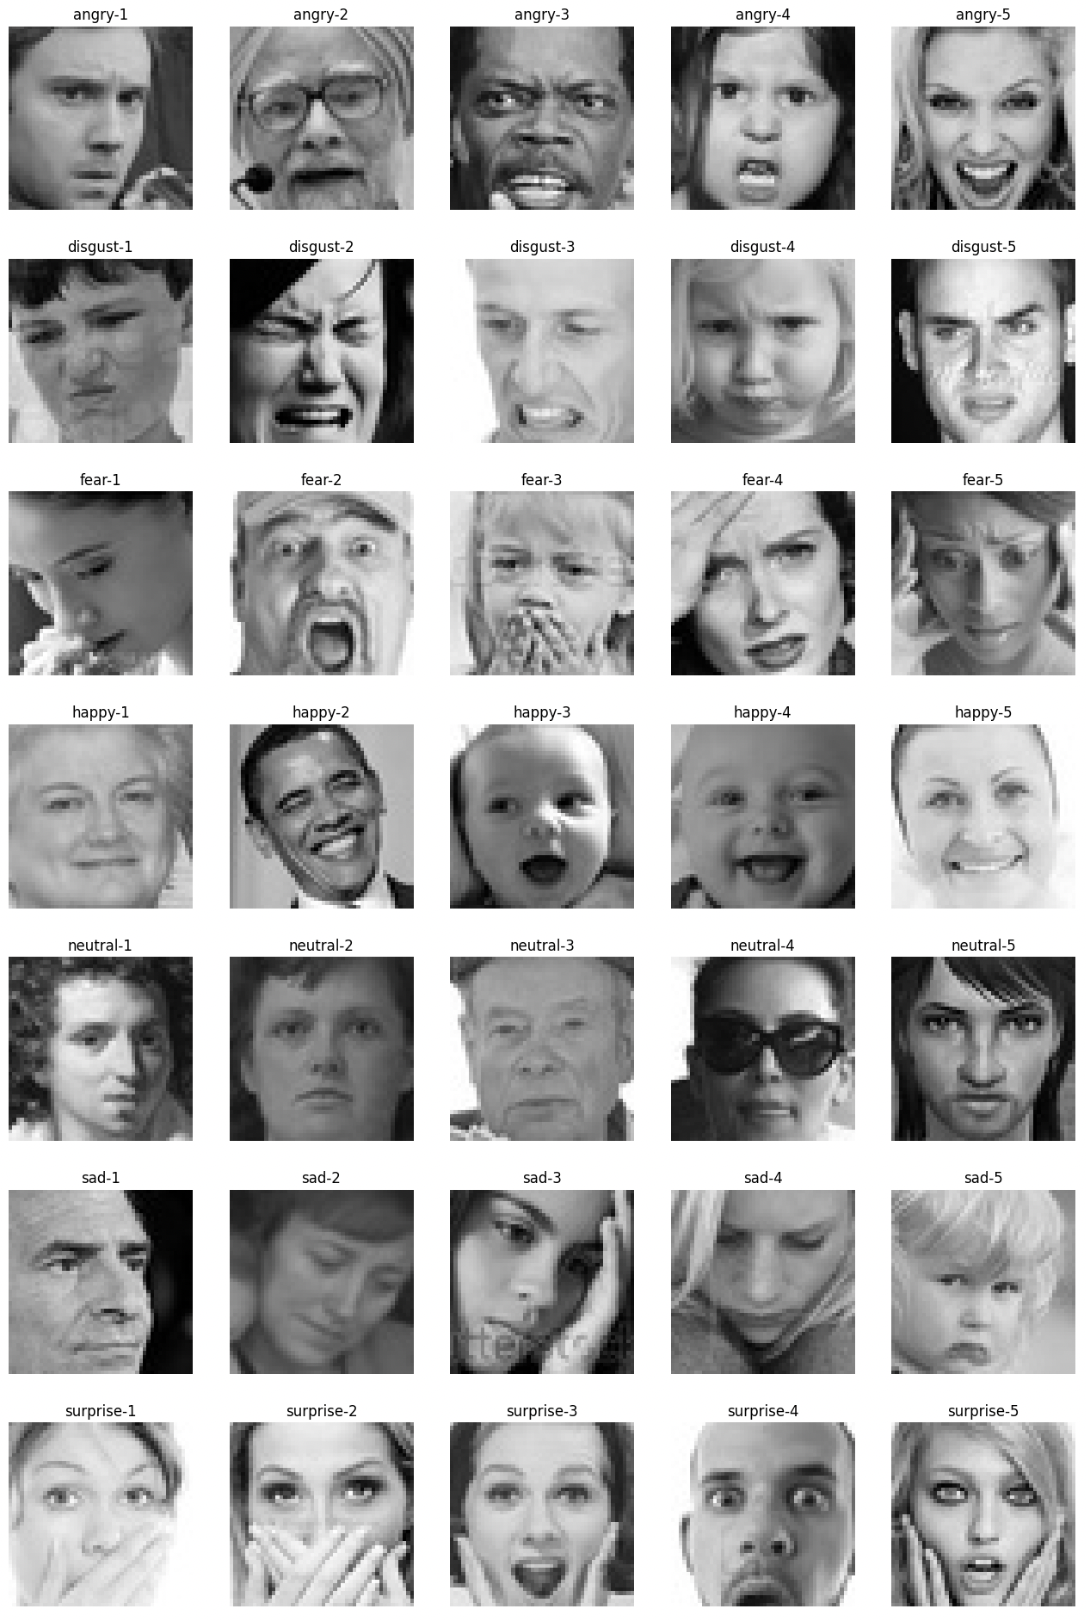

Next, we want to check the distribution of each facial expression. <br>
We defined a function, `show_distribution` to accomplish this:

In [ ]:
def show_distribution(train_dir, test_dir):
    """
        Show the fraction of emotion labels in train and test sets.
    """
    target_var = os.listdir(train_dir)
    x_train = np.array([ len(os.listdir(os.path.join(train_dir, i))) for i in target_var ])
    x_test = np.array([ len(os.listdir(os.path.join(test_dir, i))) for i in target_var ])
    label = target_var
    
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].pie(x_train, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
    axes[1].pie(x_test, labels=label, autopct='%1.1f%%',shadow=True, startangle=90)
    axes[0].set_title('Train')
    axes[1].set_title('Test')
    plt.show()

    for i in target_var:
        print('Emotion : ' + i )
        print('\tTraining : ' + str(len(os.listdir(os.path.join(train_dir, i)))) +
              '\n\t Testing : ' + str(len(os.listdir(os.path.join(test_dir, i)))))

then, we applied this function on train/test set

In [ ]:
show_distribution(train_dir, test_dir)

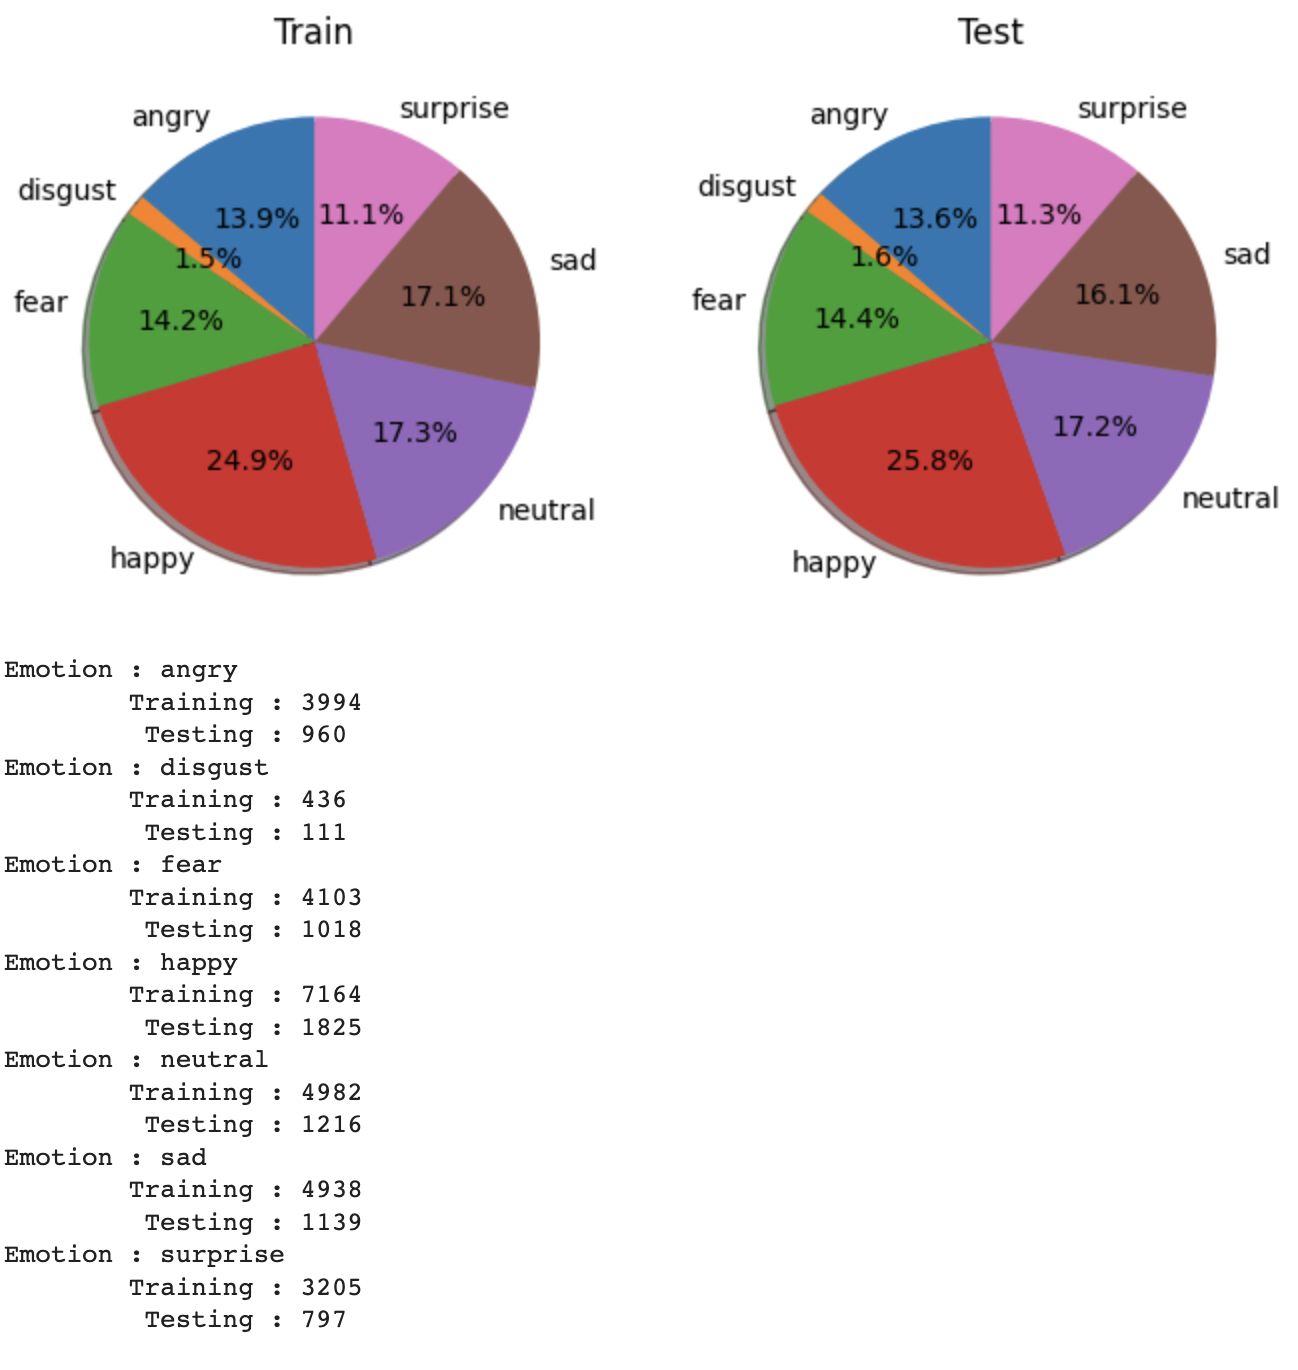

We can see that the **happy** label accounts for the largest percentage of all images, while the **disgust** images are the fewest. As **happy** images are about **26%** of all test images, we can consider it as the baseline accuracy.

## 1. Finetuning ResNet, Image Augmentation

Instead of implementing everything from scratch, we decided to finetune ResNet50.<br>
First, we began by writing a class `Resnet`.

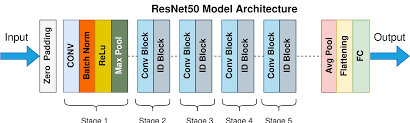

In [ ]:
class Resnet(nn.Module):
    def __init__(self, mode='finetune', pretrained=True):
        """
        use the ResNet50 model from torchvision models.
        
        mode has two options:
        1) linear: For this mode, we want to freeze ResNet50 features, then train a linear
            classifier which takes the features before FC (fully connected layer).
            Replace FC with the one takes in the features and output scores of size 7. (7 expressions)
        2) finetune: Same as 1) linear, except that we do not need to freeze the featues and
            can finetune on the pretrained resnet model.
        """
        self.resnet = models.resnet50(pretrained=Treu)
        
        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)
            
        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)
            
    def forward(self, x):
        x = self.resnet(x)
        return x
    
    def to(self, device):
        return self.resnet.to(device=device)

### 1-1. Linear Classifier
First, we started with a linear classifier

In [ ]:
# Define a model, optimizer, and criterion
model = Resnet(mode='linear', pretrained=True)

optimizer = torch.optim.SGD(
    model.parameters()
    lr = 0.005,
    momentum = 0.9
)

criterion = nn.CrossEntropyLoss()

# Define the batch size and number of workers
batch_size = 64
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)


model_name = "linear1.pt"
try:
    model.load_state_dict(torch.load(PATH + model_name))
    # continue training for more epochs:
    # train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=5)
except:
    train(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10)
torch.save(model.state_dict(), PATH + model_name)

After 10 epochs, we were able to get 40.39% validation accuracy.

### 1-2. Fully finetune with same learning rate
Then, we moved to finetuned models. <br>
We began with the learning rate of 0.01

In [ ]:
resnet_finetune1 = Resnet(mode='finetune', pretrained=True)

optimizer = torch.optim.SGD(
    resnet_finetune1.parameters(),
    lr = 0.01,
    momentum = 0.9
)

criterion = nn.CrossEntropyLoss()

### Rest are the same

For the finetuned ResNet50, we got a 61.49% validation accuracy.

### 1-3. Fully finetune with different learning rates
In ResNet50, lower layers typically learn low-level features such as edges and textures that are useful across a wide range of tasks, and therefore may require smaller updates to prevent overfitting. Meanwhile, higher layers may learn more task-specific features that require larger updates to improve performance. <br>

Therefore, we set the learning rate 'fc' layer to 0.01, and 0.001 for the rest.

In [ ]:
resnet_finetune2 = Resnet(mode='finetune', pretrained=True)

last_params, rest_params = [], []
for name, param in resnet_finetune2.named_parameters():
    if 'fc' i nname:
        last_params.append(param)
    else:
        rest_params.append(param)
        
optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

Here, we got a 64.30% validation accuracy.

### 1-4. Finetune with frozen layers
Freezing some layers during fine-tuning can help to prevent overfitting and speed up the training process. When we finetune a pre-trained neural network, we typically want to retain the learned feature representations in the lower layers of the network, which are often more general and transferable across different tasks. By freezing these lower layers, we prevent their weights from being updated during finetuning, which helps to ensure that the model retains its learned feature represenations. This can be particularly important if we have a small amount of data available for the specific task we are finetuning for. <br>

In particular, we set the last fc layer's lr to be 0.01, the first two layers's lrs to be 0, and the rest for 0.001

In [ ]:
last_params, lower_params, rest_params = [], [], []

for name, param in resnet_finetune3.named_parameters():
    if 'fc' in name:
        last_params.append(param)
    elif 'layer1' in name or 'layer2' in name:
        lower_params.append(param)
    else:
        rest_params.append(param)

optimizer = torch.optim.SGD(
    [
        {"params": last_params, "lr": 0.01, "momentum": 0.9},
        {"params": lower_params, "lr": 0, "momentum": 0.9},
        {"params": rest_params, "lr": 0.001, "momentum": 0.9}
    ]
)

Here, we got a 61.66% validation accuracy after 10 epochs.

### 1-5. Image Augmentation
While testing our finetuned models with different learning rates, we observed severe overfittings. To prevent the model learning from the same training data over and over, we used image transformations to 'virtually augment' the dataset. (Instead of adding more images to our dataset, we added the first layer that transforms our images). <br>

We tried different combinations of image transfomations, and we 
decided to use 'horizontal flip', 'random rotation' and 'random perspective' from torchvision.transforms package.

In [1]:
# image transformations
image_hflip = transforms.RandomHorizontalFlip(p=0.2) # p = probability
image_rotate = transforms.RandomRotation((-5, 5)) # degree limits
image_randomP = transforms.RandomPerspective(distortion_scale=0.1, p=0.25)

class Resnet(nn.Module):
    def __init__(self, mode='finetune', augmented=False, pretrained=True):
        super().__init__()
        """
        use the resnet18 model from torchvision models. Remember to set pretrained as true
        
        mode has two options:
        1) linear: For this mode, we want to freeze resnet18 feautres, then train a linear
                    classifier which takes the features before FC (again we do not want the resnet18 FC).
                    And then write our own FC layer: which takes in the features and 
                    output scores of size 7 (since we have 7 categories)
        2) finetune: Same as 1) linear, except that we do not need to freeze the features and
                    can finetune on the pretrained resnet model.
        """
    
            
        self.augmented = augmented
        self.resnet = models.resnet50(pretrained=True)

        if mode == 'linear':
            for name, param in self.resnet.named_parameters():
                if param.requires_grad and 'fc' not in name:
                    param.requires_grad = False
            
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

        elif mode == 'finetune':
            num_features = self.resnet.fc.in_features
            self.resnet.fc = nn.Linear(num_features, 7)

    # Here, we added a layer that transforms our images
    def forward(self, x):
        if self.augmented:
            x = image_hflip(x)
            x = image_rotate(x)
            x = image_randomP(x)
        
        x = self.resnet(x)
        return x

    def to(self, device):
        return self.resnet.to(device=device)

We tried this image augmentation with the last two models (different learning rates and the one with frozen layers), and were able to achieve a 65.51% validation accuracy after 20 epochs with the model with different learning rates.

## 2. Model Evaluation
### 2-1. Test Accuracy

After applying data augmentation on our models, we found that `resnet_finetune4` reached a higher validation accuracy (around 65%) than `resnet_finetune5` (~63%) . <br>

Now, we want to test the model `resnet_finetune4` on the unseen test dataset, and see how well our model can be generalized to unfamiliar inputs.

First, we load our test set:

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

Next, we define a function `test_evaluate` to get the model's predicted labels for the input test images. To be more specific, we set the model to be in evaluation mode uing `model.eval()`, and pass all inputs to the model with `torch.no_grad()` that will keep model parameters intact during evaluation. And the output will be the model's predicted labels.

In [ ]:
def test_evaluate(model, test_loader, device):
    """
        Pass the data in test_loader to the model,
        and get the model's predicted labels
    """

    # Evaluation mode. Use cuda if available
    try:
        model.eval().cuda() 
    except:
        model.eval()

    labels = []
    
    # Keep model parameters intact and run predictions
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs[0].to(device)
            logits = model(inputs)
            _, predictions = torch.max(logits, dim=1)

            for prediction in predictions:
                labels += [prediction.item()]

    return labels

In [ ]:
# Get predicted labels for test set
pred_labels = test_evaluate(resnet_finetune4, test_loader, device)

# How many predicted labels are correct
count = 0
true_labels = []
for i in range(len(pred_labels)):
    true_labels.append(test_dataset[i][1])
    if pred_labels[i] == test_dataset[i][1]:
        count += 1

# Percentage of correct predictions
print(count / len(pred_labels))

The model `resnet_finetune4` gives a **63%** accuracy on test dataset. This is similar to the validation accuracy, and is much higher than the baseline accuracy. Given the complex nature of facial expressions, this is a relatively satisfactory result.

### 2-2. Confusion Matrix
A good way to evaluate the performance of a classification model is to use the confusion matrix. Here we will use the `confusion_matrix` function from **sklearn** to easily achieve this.

In [ ]:
# Get the dictionaries converting from label name to index and vice versa
class2label = test_dataset.class_to_idx
label2class = {v: k for k, v in class2label.items()}

# Get the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
# Normalize confusion matrix
cm = cm/cm.astype(float).sum(axis=1)  

# Plot using heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', cbar=False, xticklabels=label2class.values(),yticklabels=label2class.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

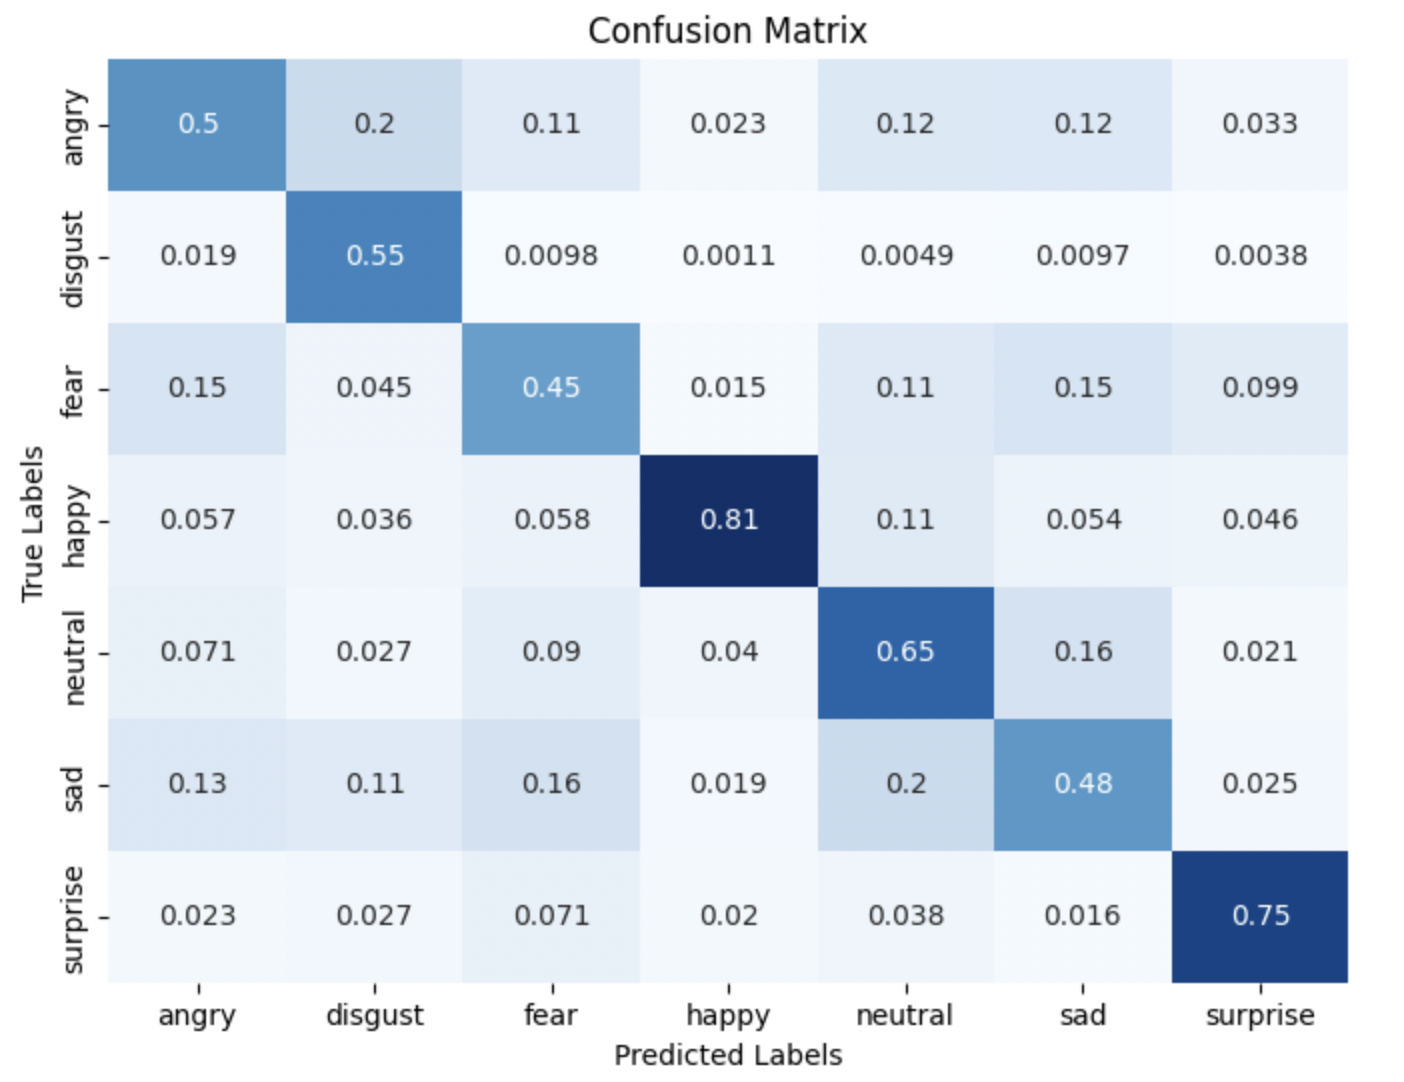

We see that the model gives best predictions on **happy** and **surprise** images, and often confuses between **fear**, **sad**, and **angry** emotions.

### 2-3. Sample Predictions
For our project, we want the facial expression analysis to be presented in the form of different fractions of each emotion, instead of one single output. This is because humans' emotions are often complex and could contain multiple emotions, and also this can help the user to decide which emotion fits the best. <br>

We defined functions `eval_sample_inputs` and `show_samples` to present the analysis on different images from the test set. And here is the result:

In [ ]:
inputs, true_labels, pred_fractions, pred_labels = eval_sample_inputs(resnet_finetune4, test_loader, device, seed=0)
show_samples(inputs, true_labels, pred_fractions, pred_labels, label2class, class2label)

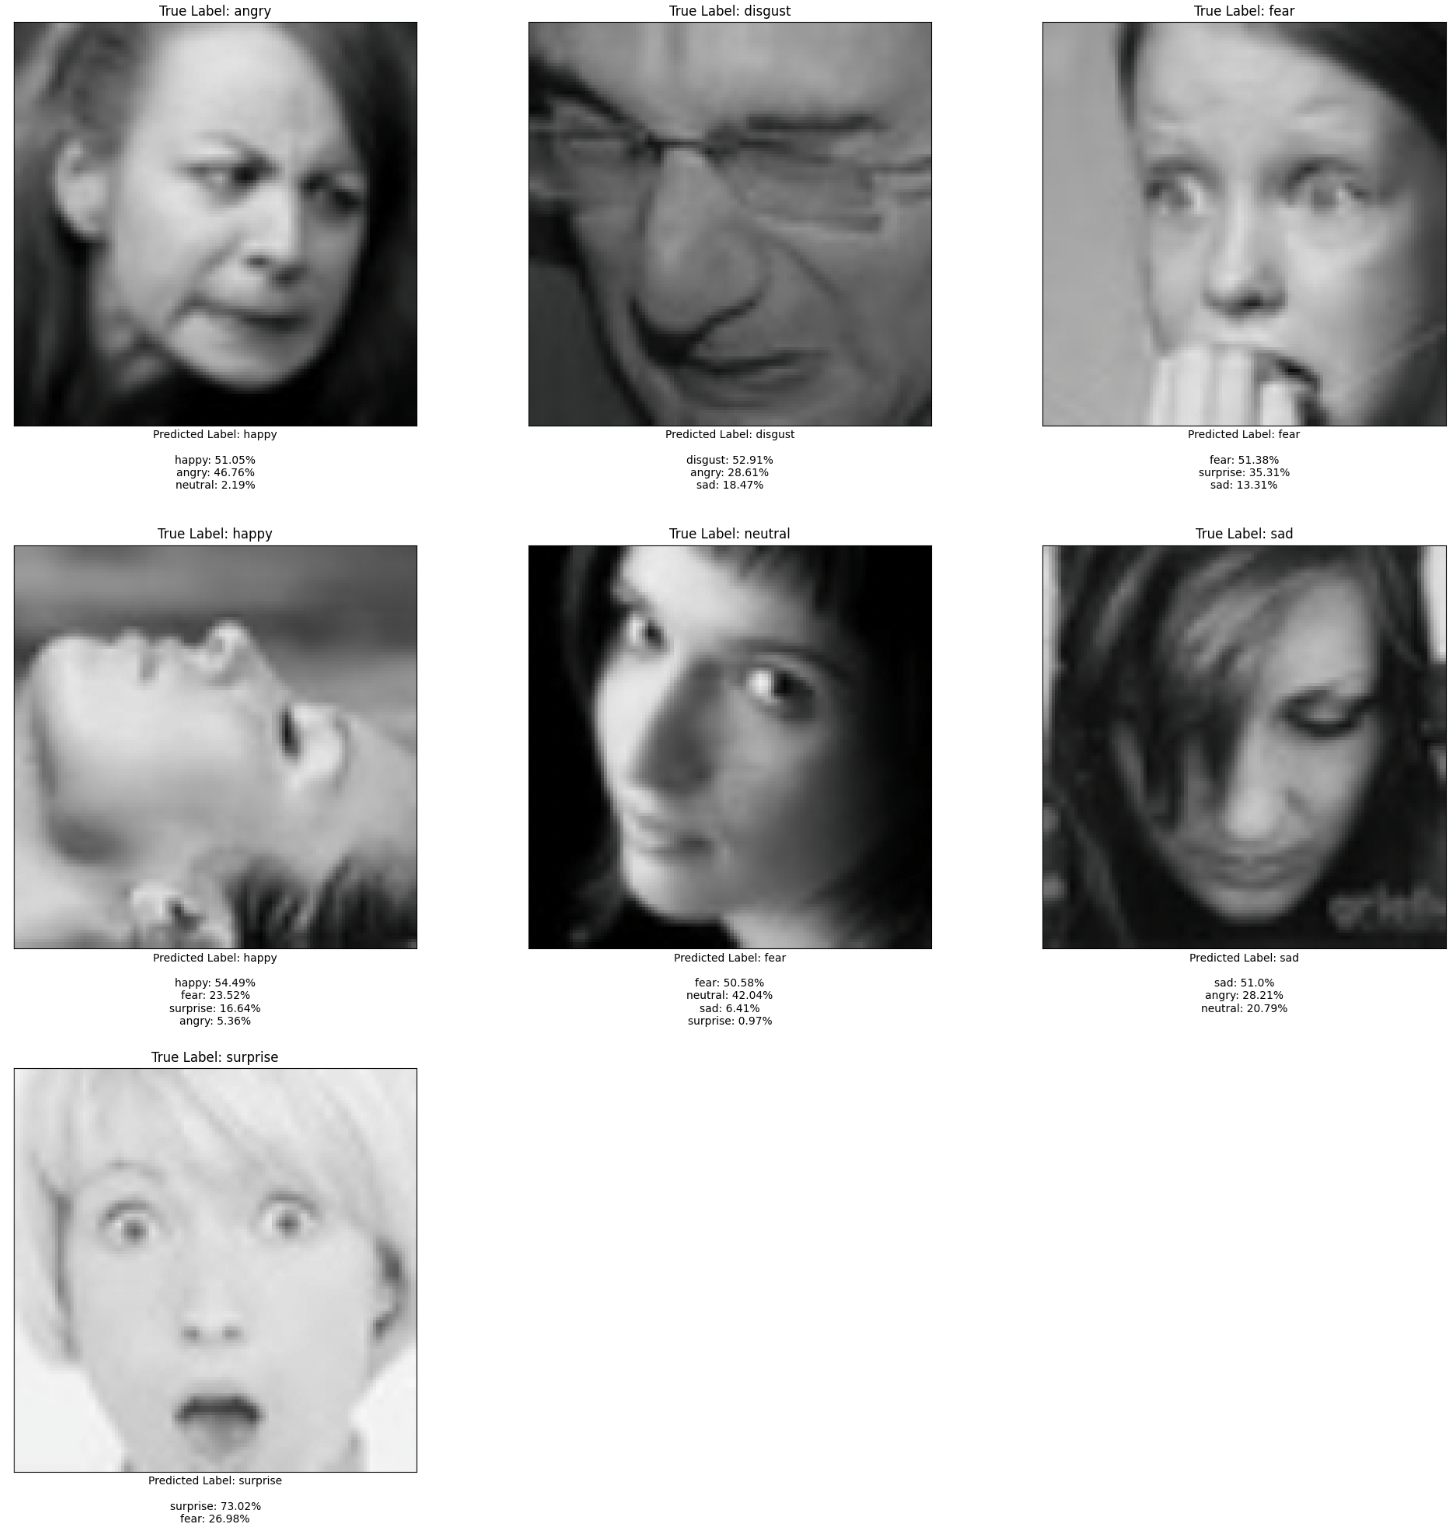

In this sample, we see that most images are correctly predicted. For the two incorrectly predicted images, the correct labels are the ones with second highest possibilities. This demonstrates the accuracy of our model is quite decent, and the utility of presenting the results in fraction form.

## 3. Flask Webapp
### 3-1. Functions that Render HTML Files

We also applied the model to a webapp and here's a demo showing how to use the facial expression detection webpage. <br>

The code snippet contains a function `upload_file` that renders the `upload.html` and anotther function `get_upload_file` that renders the `uploader.html`.

In [ ]:
# when accesing http://127.0.0.1:5000/, upload.html will be rendered
@app.route('/')
def upload_file():
   return render_template('upload.html')

# when accessing http://127.0.0.1:5000/uploader/, the following will be rendered
@app.route('/uploader', methods = ['GET', 'POST'])
def get_upload_file():
   if request.method == 'POST':
    # request the file that the user uploaded and save in static folder
      f = request.files['file']
      f.filename="./static/"+f.filename
      f.save(f.filename)

    # read the saved image and convert to format we want
      img = Image.open(f.filename)
      img = img.convert('RGB')  # to RGB
      img = transforms.Grayscale(num_output_channels=3)(img) # Grayscale
      img = transforms.Resize((128, 128))(img)  # resize to 128*128
      img = transforms.ToTensor()(img)  # to pytorch tensor
      img = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])(img) # normalize
      
      pred_fraction = None
      pred_label = None
      # Enter evaluation mode and pass image to the model
      # And get predicted labels and their fractions
      model.eval()
      with torch.no_grad():
         logit = model(torch.tensor(np.expand_dims(img,axis=0)).to(device)).detach().cpu().numpy()
         logit = np.maximum(logit, 0)    # relu
         pred_fraction = logit / np.sum(logit)  # normalize
         pred_label = np.argmax(logit)
    # Sort fractions, get rid of zero fraction labels
      frac = pred_fraction[0]
      sorted_id = np.flip(np.argsort(frac))
      valid_id = frac[sorted_id]!=0   # excluding zero fractions
      sorted_id = sorted_id[valid_id] # id of sorted fractions, big to small
    # write results to a long string
      xlab = ""
      for id in sorted_id:
         xlab += list(class2label.keys())[id]
         xlab += ': '
         xlab += str(np.round(pred_fraction[0][id]*100,2))
         xlab += "%\n"

      return render_template('uploader.html', img=f.filename,result=xlab,predict=label2class[pred_label])

### 3-2. Submit page.

The following code is from the `upload.html`. The `upload` template has buttons to select the image to be uploaded and submit it so that the model can analyze facial expressions from it.

In [ ]:
<html>
    # link to the css file
   <link rel="stylesheet" type="text/css" href= {{ url_for("static",filename="mystyle.css") }} >
   <body>
      <h1>Upload your face image here!</h1>
      <br><br>
      <form action = "/uploader" method = "POST" 
         enctype = "multipart/form-data">
         <input type = "file" name = "file" />
         <input type = "submit"/>
      </form>
      <br> 
   </body>
</html>

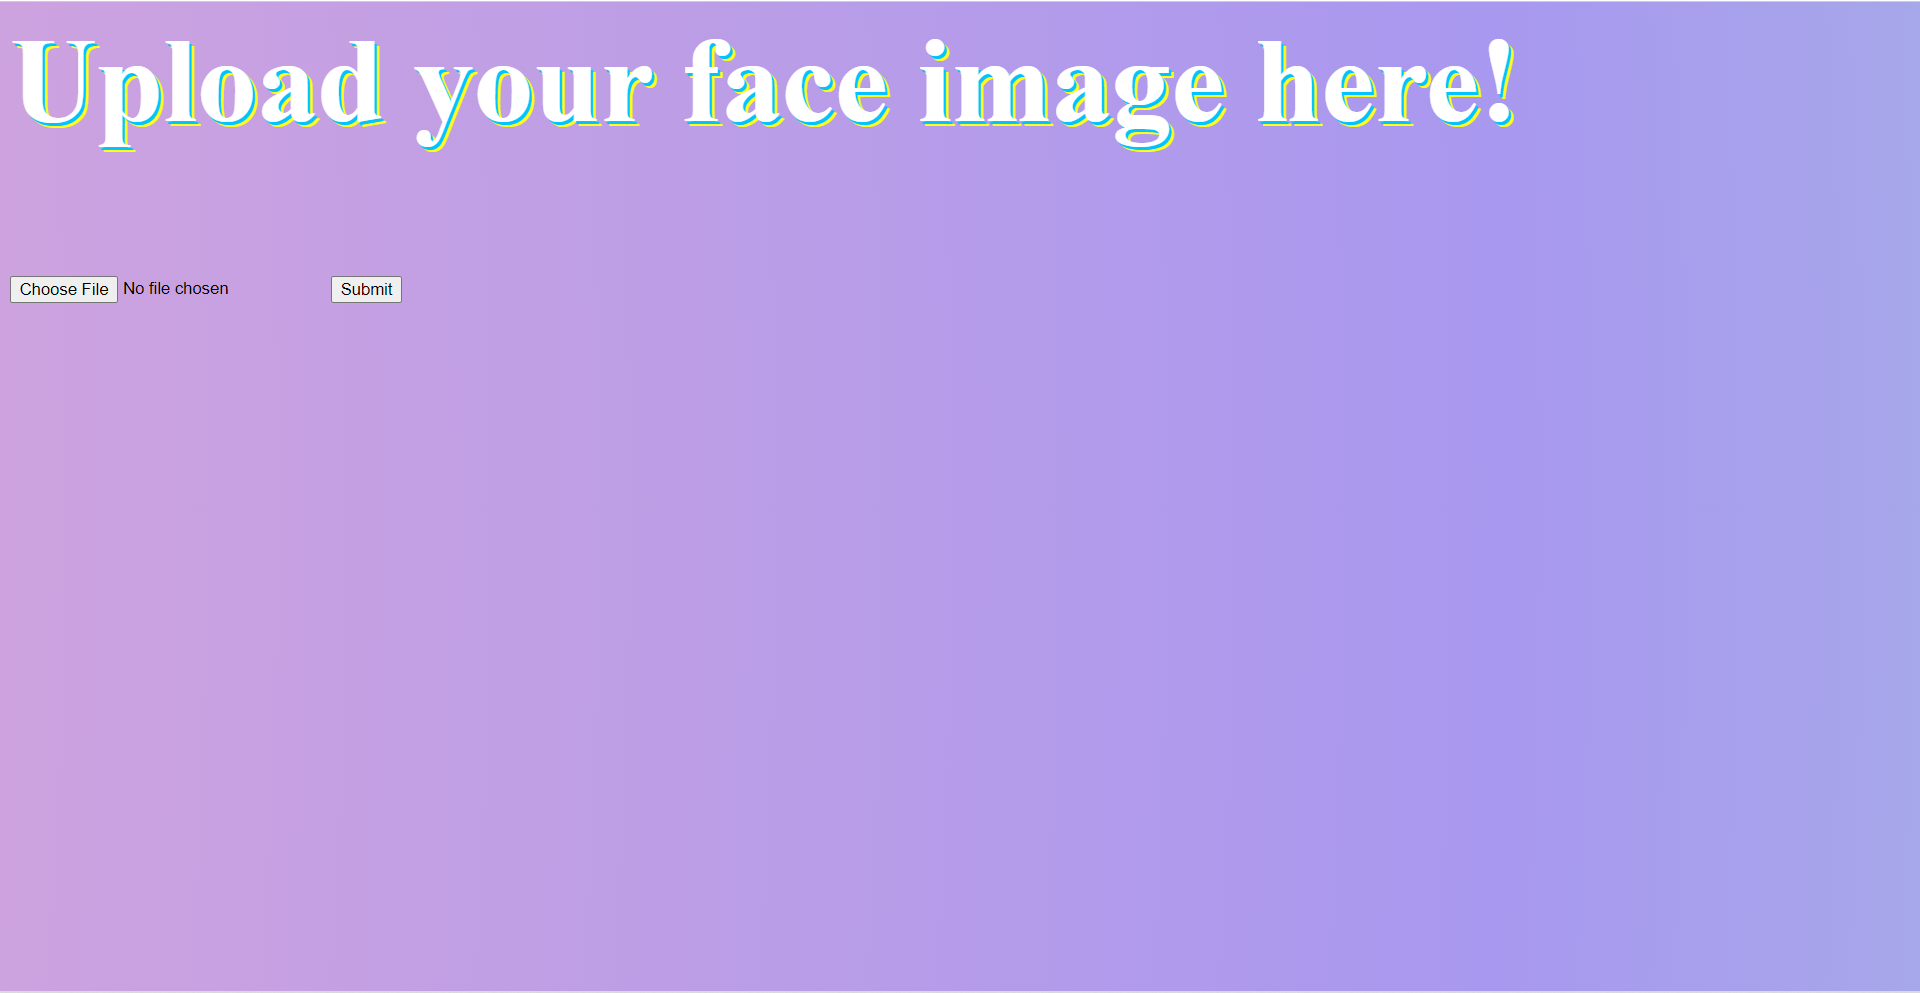

After clicking the `Choose File` button and select an image from your computer, you can click the `Submit` button that leads you to the `uploader` page. <br>

Quick Note: The user should crop the image to make sure the face is at around the center.

### 3-3. Result Page

The following code is from the `uploader.html`. The `uploader` template shows the image you uploaded and the percentages of all facial expressions the model detects.

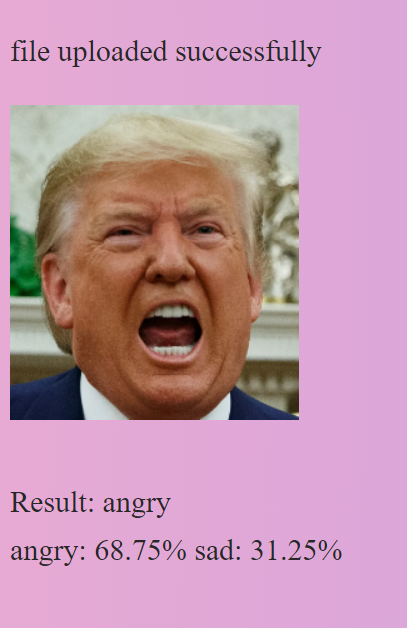

For example, if you upload an angry Trump image to the webpage, you will get a page like this!

## 4. Conclusion

Such face detection can be used in a broad variety of scenarios, and serve as a basic foundation for more complicated CV implementations. <br>
It could benefict the public as many useful applications such as autonomous vehicle, portrait beautification are all based on face(or object) recognition, and they can bring great convenience to people's lives. <br>
However, if the facial recognition is used in other applications like next-level  surveilance, this may have the potential to violate each individual's privacy. <br>
 
To prevent any possible data leaks from this project, we decided not to deploy our webapp (it runs on a local server instead), so that the images and personal data cannot be leaked or used in inappropriate ways.